In [3]:
# Enable current type hints for older Python version (<3.10) 
from __future__ import annotations
import boto3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [4]:
from dotenv import dotenv_values

config = dotenv_values(".env")

BUCKET_NAME = config['BUCKET_NAME']
PREFIX = config['PREFIX']
FILE_NAME = config['FILE_NAME']
TRAINING_DATA_PATH = config['TRAINING_DATA_PATH']
VALIDATION_DATA_PATH = config['VALIDATION_DATA_PATH']

In [5]:
# Todo: Remove this once using feature store
import pickle
with open('df_test.pickle', 'rb') as f:
    df_test: pd.DataFrame = pickle.load(f)

In [6]:
import sagemaker

role = sagemaker.get_execution_role()
region_name = boto3.Session().region_name
image = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print(f"Using SageMaker BlazingText image: {image} ({region_name})")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


Using SageMaker BlazingText image: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:1 (us-east-1)


In [12]:
def create_model_inputs(input_path_train, input_path_val):
    train_data = sagemaker.inputs.TrainingInput(
        f's3://{input_path_train}',
        distribution="FullyReplicated",
        content_type="text/plain",
        s3_data_type="S3Prefix",
    )
    validation_data = sagemaker.inputs.TrainingInput(
        f's3://{input_path_val}',
        distribution="FullyReplicated",
        content_type="text/plain",
        s3_data_type="S3Prefix",
    )
    data_channels = {"train": train_data, "validation": validation_data}
    return data_channels


data_channels = create_model_inputs(input_path_train=TRAINING_DATA_PATH, input_path_val=VALIDATION_DATA_PATH)

In [24]:
# Specify search range based on AWS recommended balues
# ( https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext-tuning.html )
tuning_job_config = {
    "ParameterRanges": {
      "CategoricalParameterRanges": [],
      "ContinuousParameterRanges": [
        {
          "MaxValue": "0.01",
          "MinValue": "0.005",
          "Name": "learning_rate"
        }
      ],
      "IntegerParameterRanges": [
        {
          "MaxValue": "10000000",  # 10M
          "MinValue": "1000000",  # 1M
          "Name": "buckets"
        },
        {
          "MaxValue": "15",
          "MinValue": "5",
          "Name": "epochs"
        },
        {
          "MaxValue": "100",
          "MinValue": "0",
          "Name": "min_count"
        },
        {
          "MaxValue": "300",
          "MinValue": "32",
          "Name": "vector_dim"
        },
        {
          "MaxValue": "3",
          "MinValue": "1",
          "Name": "word_ngrams"
        }          
      ]
    },
    "ResourceLimits": {
      "MaxNumberOfTrainingJobs": 3,
      "MaxParallelTrainingJobs": 1
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
      "MetricName": "validation:accuracy",
      "Type": "Maximize"
    }
  }

In [36]:
training_job_definition = {
    "AlgorithmSpecification": {
      "TrainingImage": image,
      "TrainingInputMode": "File"
    },
    "InputDataConfig": [
      {
        "ChannelName": "train",
        "CompressionType": "None",
        "ContentType": "text/plain",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": f's3://{TRAINING_DATA_PATH}'
          }
        }
      },
      {
        "ChannelName": "validation",
        "CompressionType": "None",
        "ContentType": "text/plain",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": f's3://{VALIDATION_DATA_PATH}'
          }
        }
      }
    ],
    "OutputDataConfig": {
      "S3OutputPath": f's3://{BUCKET_NAME}/{PREFIX}/output'
    },
    "ResourceConfig": {
      "InstanceCount": 1,
      "InstanceType": "ml.c4.4xlarge",
      "VolumeSizeInGB": 30
    },
    "RoleArn": role,
    "StaticHyperParameters": {
        "mode": "supervised",
        "early_stopping": "True",
        "patience": "4",
    },
    "StoppingCondition": {
      "MaxRuntimeInSeconds": 1000
    }
}

In [37]:
smclient = boto3.Session().client('sagemaker')

tuning_job_name = f"email-bt-{datetime.now():%m-%d-%H-%M-%S}"
hp_job = smclient.create_hyper_parameter_tuning_job(
    HyperParameterTuningJobName = tuning_job_name,
    HyperParameterTuningJobConfig = tuning_job_config,
    TrainingJobDefinition = training_job_definition
)
hp_job

In [51]:
tuning_job_result = smclient.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)
# tuning_job_result

In [80]:
hp_results = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name) \
    .dataframe()
hp_results.FinalObjectiveValue.max()

0.9314000010490417

<AxesSubplot:xlabel='FinalObjectiveValue', ylabel='TrainingJobName'>

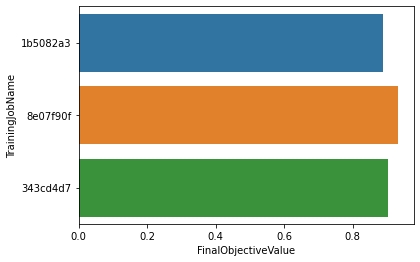

In [78]:
sns.barplot(
    y=hp_results.TrainingJobName.str.split('-').str.get(-1), 
    x=hp_results.FinalObjectiveValue
)

In [49]:
# from sagemaker.serializers import JSONSerializer
# def train_and_deploy(inputs):
#     est = sagemaker.estimator.Estimator(
#         image,
#         role,
#         instance_count=1,
#         instance_type="ml.c4.4xlarge",
#         volume_size=30,
#         max_run=360000,
#         input_mode="File",
#         output_path=output_path,
#         hyperparameters={
#             "mode": "supervised",
#             "epochs": 3,
#             "min_count": 2,
#             "learning_rate": 0.05,
#             "vector_dim": 100,
#             "early_stopping": True,
#             "patience": 4,
#             "min_epochs": 5,
#             "word_ngrams": 2,
#         },
#     )
#     est.fit(inputs=data_channels, logs=True)# using the same nltk tokenizer that we used during data preparation for training

#     deployed_model = est.deploy(
#         initial_instance_count=1, instance_type="ml.m5.xlarge", serializer=JSONSerializer()
#     )
#     return est, deployed_model

# _, deployed_model = train_and_deploy(inputs=data_channels)

## Evaluate model
### Make predictions
Let's get the test data and get the associated predictions from the Sagemaker endpoint we deployed in the previous step.

In [ ]:
import json

# Save as np array for easy splitting later
replied_tos = df_test.loc[df.target == '__label__reply', 'feature'].values
no_reply = df_test.loc[df.target == '__label__no_reply', 'feature'].values

In [ ]:
def _prediction_to_df_row(pred: dict) -> dict:
    labels = pred['label']
    probs = pred['prob']
    return {
        label: prob 
        for label, prob in zip(labels, probs)
    }

def get_probs(text: np.array, deployed_model) -> list[np.float]:
    payload = {
        "instances": text,
        "configuration": {"k": 2},  # get probs for top-k (both) classes
    }
    response = deployed_model.predict(payload)
    predictions = json.loads(response)

    all_probs = [
        _prediction_to_df_row(pred) for pred in predictions
    ]
    return pd.DataFrame(all_probs)['__label__reply']

p_reply = get_probs(replied_tos, deployed_model=deployed_model)
p_reply.describe()


In [ ]:
# Need to make 2 requests
p_no_reply = pd.concat(
    [
        get_probs(no_reply[:2000], deployed_model=deployed_model),
        get_probs(no_reply[2000:], deployed_model=deployed_model)
    ],
    axis=0
)
p_no_reply.describe()

### Model performance

In [ ]:
# Vectors of true and predicted scores
y_true = [1] * len(replied_tos) + [0] * len(no_reply)
y_score = p_reply.append(p_no_reply)

y_score.describe()

In [ ]:
# AUC
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
roc_auc_score(y_true=y_true, y_score=y_score)

The AUC of .9 is pretty good, but  it can be misleading for an imbalanced classification problem (remember, we only oversampled the training and validation data). Thus, let's look at the confusion matrix for a more detailed view.

In [ ]:
cm = confusion_matrix(y_true=y_true, y_pred=y_score>0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no reply', 'replied to'])
disp = disp.plot()
plt.show()

We see that if we just predict the most probable class, we can correctly predict about 60% of replies. This is pretty good for predicting a rare event. Depending on what we care about, we could adjust the prediction threshold. For example, if we care about identifying messages that could potentially require a reply, we could flag each message that has a probability of reply greater than 10%. Let's see what results this gives us:

In [ ]:
print(
    classification_report(y_true=y_true, y_pred=y_score>0.5, target_names=['no reply', 'replied to'])
)

In [ ]:
cm = confusion_matrix(y_true=y_true, y_pred=y_score>0.1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no reply', 'replied to'])
disp = disp.plot()
plt.show()

In [ ]:
print(
    classification_report(y_true=y_true, y_pred=y_score>0.1, target_names=['no reply', 'replied to'])
)

Now we are able to identify almost all emails eliciting a reply, at the cost of more false positives.

In [ ]:
sess.delete_endpoint(deployed_model)

In [ ]:
print(f'Finished at {datetime.now()}')